In [ ]:
# fmt: off

### Necessary Imports

In [2]:
import numpy as np

from rtdip_sdk.pipelines.data_quality import KSigmaAnomalyDetection, IntervalFiltering, ArimaPrediction, MissingValueImputation
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import math
import random

spark_session = SparkSession.builder.master("local[2]").appName("test").getOrCreate()


/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
25/01/14 16:14:28 WARN Utils: Your hostname, anons-Laptop resolves to a loopback address: 127.0.1.1; using 10.100.32.12 instead (on interface wlo1)
25/01/14 16:14:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/14 16:14:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/14 16:14:31 WARN Utils: Service 'SparkUI' coul

### Introduction

I'm [name], a Data Engineer at Shell. [More Explanation to why to do that.]

### Source of Data

The source data is sourced from the data given from Shell.

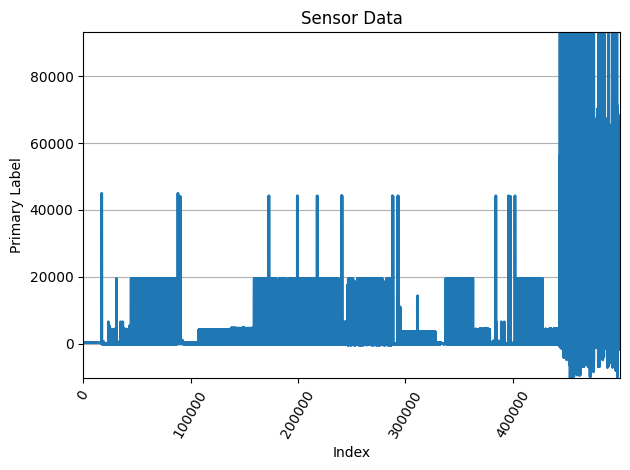

<Figure size 640x480 with 0 Axes>

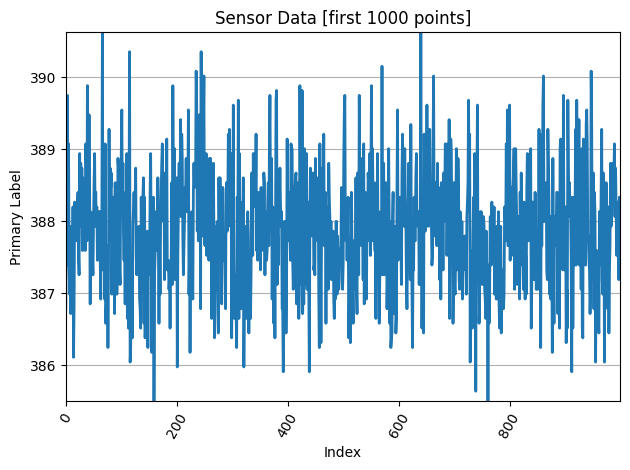

<Figure size 640x480 with 0 Axes>

In [10]:
source_df = pd.read_pickle('./ExampleData.pkl')

def create_value_plot(value_df = None, secondary_value_df = None, title = 'Unnamed Plot', x_label = 'Index', y_label = 'Primary Label', secondary_y_label = 'Secondary Value', share_y_axis = False):
    fig, ax = plt.subplots()
    solar_line = ax.plot(value_df, label=y_label, linewidth=2)
    ax.set_xlabel(x_label)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_ylim([value_df.min(), value_df.max()])
    ax.set_xlim([value_df.index.min(), value_df.index.max()])
    ax.grid(axis='y')

    if secondary_value_df is not None:
        ax2 = ax.twinx()
        color='tab:red'
        ax2.set_ylabel(secondary_y_label, color=color)
        ax2.plot(secondary_value_df, color=color, linewidth=3, linestyle = '--')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_ylim([secondary_value_df.min(), secondary_value_df.max()] if not share_y_axis else [0, value_df.max()])

    fig.tight_layout()
    plt.show()
    plt.clf()

create_value_plot(source_df['Value'], title='Sensor Data')
create_value_plot(source_df['Value'][0:1000], title='Sensor Data [first 1000 points]')


### Normalization
*Scenario*:
We want to normalize sensor data, so it better used in other components or Machine Learning applications.
We show our three implemented methods of normalization: Z-score, min-max & mean.
The denormalization of data is also supported, e. g. for storing processed data in a human-readable format.

In [ ]:
def create_normalization_plot(input_df = None, normalized_df = None, title = 'Solar Energy produced in Germany', ylabel_2 = 'Normalized Value', share_y_axis = False):
    fig, ax = plt.subplots()
    solar_line = ax.plot(input_df['Solar  - Actual Aggregated [MW]'], label='Solar', linewidth=2)
    ax.set_xlabel('Time')
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
    ax.set_ylabel('Produced Energy [MW]')
    ax.set_title(title)
    ax.set_ylim([0, input_df['Solar  - Actual Aggregated [MW]'].max()])
    ax.set_xlim([input_df.index.min(), input_df.index.max()])
    ax.grid(axis='y')
    
    if normalized_df is not None:
        ax2 = ax.twinx()
        color='tab:red'
        ax2.set_ylabel(ylabel_2, color=color)
        ax2.plot(normalized_df['value'], color=color, linewidth=3, linestyle = '--')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_ylim([normalized_df['value'].min(), normalized_df['value'].max()] if not share_y_axis else [0, input_df['Solar  - Actual Aggregated [MW]'].max()])
        
    fig.tight_layout()
    plt.show()

create_normalization_plot(create_1_week_dataframe())

In [ ]:
# Setup Data
april_df = create_1_week_dataframe()
s_df = spark_session.createDataFrame(april_df['Solar  - Actual Aggregated [MW]'].to_frame(), ['value'])
# Prepare Pipelines
min_max_norm = NormalizationMinMax(df=s_df, column_names=['value'], in_place=True)
mean_norm = NormalizationMean(df=s_df, column_names=['value'],
                              in_place=True)
z_score_norm = NormalizationZScore(df=s_df, column_names=['value'],
                                   in_place=True)
# Normalize with all 3 methods
min_max_df = min_max_norm.filter().toPandas().set_index(april_df.index)
mean_df = mean_norm.filter().toPandas().set_index(april_df.index)
z_score_df = z_score_norm.filter()
# Denormalization of Z-Score DF
denorm = Denormalization(df=z_score_df, normalization_to_revert=z_score_norm)
z_score_df = z_score_df.toPandas().set_index(april_df.index)
denorm_df = denorm.filter().toPandas().set_index(april_df.index)

In [ ]:
create_normalization_plot(input_df=april_df, normalized_df=min_max_df, title='Solar Energy produced in Germany - Min Max Normalization', ylabel_2='Min Max Normalized Value')
create_normalization_plot(input_df=april_df, normalized_df=mean_df, title='Solar Energy produced in Germany - Mean Normalization', ylabel_2='Mean Normalized Value')
create_normalization_plot(input_df=april_df, normalized_df=z_score_df, title='Solar Energy produced in Germany - Z-Score Normalization', ylabel_2='Z-Score Normalized Value')
create_normalization_plot(input_df=april_df, normalized_df=denorm_df, title='Solar Energy produced in Germany - Denormalized from Z-Score Normalization', ylabel_2='Denormalized Value')

### Duplicate Detection
*Scenario*:
Because of some error reading in the sensor data, some entries are duplicated.
Cleaning these will decrease the size of the dataframe without losing any information.


In [ ]:
dd_df = pd.DataFrame(data={
    'TagName' : ['Temperature_Sensor', 'Temperature_Sensor', 'Temperature_Sensor'],
    'EventTime' : ['2024-01-02 20:03:46.000', '2024-01-02 20:03:46.000', '2024-01-02 20:03:47.000'],
    'Value' : [5.0, 5.0, 7.0]
})
print('Before Duplicate Detection')
print(dd_df.head())

s_dd_df = spark_session.createDataFrame(dd_df, ['TagName', 'EventTime', 'Value'])
output_dd_df = DuplicateDetection(df=s_dd_df).filter().toPandas().sort_values('EventTime')
print('\nAfter Duplicate Detection')
print(output_dd_df.head())



### Sigma Anomaly Detection
*Scenario*:
In raw sensor data, there are sometimes measurement outliers or errors, which pollute the data.
Identifying these spikes and removing them improves the data quality.

In [ ]:
random.seed(0)
# Create data with randomized spikes
sa_april_df = create_1_week_dataframe(only_aggregated_value=True, add_timeevent_col=True)
for i in range(0, 20):
    sa_april_df.loc[random.choice(sa_april_df.index.to_list()), 'Solar  - Actual Aggregated [MW]'] = 100000
s_dd_df = spark_session.createDataFrame(sa_april_df, ['Solar  - Actual Aggregated [MW]', 'EventTime'])
# Execute Pipeline
output_dd_ps_df = KSigmaAnomalyDetection(spark_session, df=s_dd_df, column_names=['Solar  - Actual Aggregated [MW]'], k_value=3.0, use_median=False).filter()
# Transform Data back into pandas
output_dd_df = output_dd_ps_df.toPandas().set_index('EventTime')
output_dd_df['value'] = output_dd_df['Solar  - Actual Aggregated [MW]']
    
create_normalization_plot(input_df=sa_april_df, normalized_df=output_dd_df, title='Solar Energy produced in Germany - With Anomalies', share_y_axis=True, ylabel_2='Corrected Produced Energy (k sigma filtering) [MW]')


### Interval Filtering
*Scenario*:
Interval Filtering ensures, that the points in a dataframe are roughly equally in time, so that between two adjacent points roughly the same time period passes.
When working with too large data sets, some models are computationally too expensive to train on the whole dataset.
Interval Filtering can be used to reduce the amount of points in the data set, which allows it to be used e.g. for ARIMA-modelling.

In [ ]:
# Data Preparation
april_df = create_2_week_dataframe()
intf_april_df = create_2_week_dataframe(only_aggregated_value=True, add_timeevent_col=True)
intf_april_df['EventTime'] = pd.Series(intf_april_df['EventTime'], dtype="string")
intf_ps_df = spark_session.createDataFrame(intf_april_df, ['Solar  - Actual Aggregated [MW]', 'EventTime'])
# Pipeline Execution
output_intf_df = IntervalFiltering(spark_session, df=intf_ps_df, interval=2, interval_unit='hours', time_stamp_column_name='EventTime').filter().toPandas()
# Postprocessing of DataFrame
output_intf_df['value'] = output_intf_df['Solar  - Actual Aggregated [MW]']
output_intf_df['EventTime'] = pd.to_datetime(output_intf_df['EventTime'])
output_intf_df = output_intf_df.set_index('EventTime')

create_normalization_plot(input_df=april_df,normalized_df=output_intf_df, ylabel_2='Interval filtered Value to 6 hours')

### ARIMA Prediction
*Scenario*:
We want to predict how much solar energy will be used next week. For that we will apply the reduced data from Interval Filtering on a ARIMA-Model.

In [ ]:
# Reuse Output Dataframe from Interval Filtering, since that reduces amount of points needed to a manageable amount
arima_comp_df = output_intf_df.copy(deep=True)
arima_comp_df.drop(arima_comp_df.tail(1).index, inplace=True)
half_size = math.ceil(arima_comp_df.shape[0]/2)
arima_input_df = arima_comp_df.head(half_size)
arima_ps_df = spark_session.createDataFrame(
        arima_input_df,
        ['Solar  - Actual Aggregated [MW]', 'EventTime']
    )
# Pipeline Execution
arima_comp = ArimaPrediction(arima_ps_df, column_name='Solar  - Actual Aggregated [MW]', number_of_data_points_to_analyze=half_size, number_of_data_points_to_predict=half_size,
                             order=(2,0,0), seasonal_order=(5,0,0,half_size/7), trend='n')
forecasted_df = arima_comp.filter().toPandas()
# Postprocessing Data

forecasted_df['value'] = forecasted_df['Solar  - Actual Aggregated [MW]']
forecasted_df['EventTime'] = pd.to_datetime(arima_comp_df.index)
forecasted_df = forecasted_df.set_index('EventTime')

create_normalization_plot(input_df=april_df, normalized_df=forecasted_df.tail(half_size), title='Solar Energy produced in Germany - Prediction with ARIMA', ylabel_2='Forecasted Solar - Actual Aggregated [MW]', share_y_axis=True)


### Value Imputation
*Scenario*:
Sometimes a value is missing because of sensor error or similar issues. This makes it difficult to use these time series on algorithms expecting a time series without gaps. To fix that issue, Value Imputation is used to fill in these gaps with meaningful values.



In [ ]:
random.seed(0)
# Create data with randomized gaps
vi_april_df = create_1_week_dataframe(only_aggregated_value=True, add_timeevent_col=True, add_tagname=True, add_status=True)
for i in range(0, 50):
    chosen_index = random.choice(sa_april_df.index.to_list())
    vi_april_df.loc[chosen_index, 'Solar  - Actual Aggregated [MW]'] = np.NaN
    vi_april_df.loc[chosen_index, 'Status'] = 'Bad'
vi_ps_df = spark_session.createDataFrame(vi_april_df, ['Value', 'EventTime', 'TagName', 'Status'])
print('Before Value Imputation')
vi_ps_df.show()
# Execute Pipeline
output_vi_ps_df = MissingValueImputation(spark_session, df=vi_ps_df).filter()
print('After Value Imputation')
output_vi_ps_df.show()
# Transform Data back into pandas
output_vi_df = output_dd_ps_df.toPandas().set_index('EventTime')
output_vi_df['value'] = output_vi_df['Solar  - Actual Aggregated [MW]']

create_normalization_plot(input_df=vi_april_df, title='Solar Energy produced in Germany - With Anomalies', share_y_axis=True, ylabel_2='Corrected Produced Energy (value imputation) [MW]')

create_normalization_plot(input_df=output_vi_df, title='Solar Energy produced in Germany - Corrected Anomalies')
